In [310]:
import pandas as pd
import numpy as np

# Step 1: Import the dataset into a dataframe
df = pd.read_csv('golf_raw.csv')

# Step 2: Import 2024 Open Championship player list
open_list = pd.read_csv('2024openlist.csv')

# Step 3: Filter out players in the 2024 Open list who are not present in the original dataset
open_dg_ids = set(open_list['dg_id'])
df = df[df['dg_id'].isin(open_dg_ids)]

# Step 4: Drop the specified columns
columns_to_drop = ['tour', 'year', 'season', 'event_completed', 'event_name', 'round_num', 'course_name', 'fin_text', 'course_num', 'course_par', 'start_hole', 'teetime']
df = df.drop(columns=columns_to_drop)

# Step 5: Import the player dictionary
player_dict = pd.read_csv('playernames.csv')

# Step 6: Function to choose aggregate method based on skewness
def choose_aggregate_method(df, column):
    if df[column].skew() > 1 or df[column].skew() < -1:
        return 'median'
    else:
        return 'mean'

# Create a dictionary to hold the chosen methods
chosen_methods = {}

# Determine which aggregate method to use for each column
for col in df.columns:
    if col not in ['dg_id', 'player_name']:
        method = choose_aggregate_method(df, col)
        chosen_methods[col] = method

# Step 7: Aggregating the data
aggregated_data = df.groupby('dg_id').agg(chosen_methods).reset_index()

# Step 8: Filter out dg_ids in the 2024 Open list that are not in the original dataset
valid_open_list = open_list[open_list['dg_id'].isin(aggregated_data['dg_id'])]

# Step 9: Ensure only valid dg_ids from the original dataset
filtered_data = aggregated_data[aggregated_data['dg_id'].isin(valid_open_list['dg_id'])]

# Step 10: Calculate percentiles for the round_score
filtered_data['round_score_percentile'] = filtered_data['round_score'].rank(pct=True) * 100

# Function to impute missing values based on percentile
def impute_missing_values(row, percentile_column, columns_to_impute):
    for col in columns_to_impute:
        if pd.isnull(row[col]):
            percentile = row[percentile_column]
            col_percentile_value = np.percentile(filtered_data[col].dropna(), percentile)
            row[col] = col_percentile_value
    return row

columns_to_impute = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total', 'driving_dist', 'driving_acc', 'gir', 'scrambling', 'prox_rgh', 'prox_fw', 'great_shots', 'poor_shots']

# Apply the impute function to each row
filtered_data = filtered_data.apply(impute_missing_values, axis=1, args=('round_score_percentile', columns_to_impute))

# Drop the percentile column after imputation
filtered_data = filtered_data.drop(columns=['round_score_percentile'])

# Step 11: Display descriptive statistics for the resulting dataframe (excluding dg_id)
print("\nDescriptive statistics for the resulting dataframe (excluding dg_id):")
print(filtered_data.drop(columns=['dg_id']).describe())

# Calculate additional statistics for rounds aggregated per player
rounds_per_player = df.groupby('dg_id').size()
valid_rounds = rounds_per_player[rounds_per_player.index.isin(filtered_data['dg_id'])]

average_rounds = valid_rounds.mean()
max_rounds = valid_rounds.max()
min_rounds = valid_rounds.min()
max_player = valid_rounds.idxmax()
min_player = valid_rounds.idxmin()

max_avg_driving_dist_player = filtered_data.loc[filtered_data['driving_dist'].idxmax(), 'dg_id']
max_avg_driving_dist_value = filtered_data['driving_dist'].max()

min_avg_round_score_player = filtered_data.loc[filtered_data['round_score'].idxmin(), 'dg_id']
min_avg_round_score_value = filtered_data['round_score'].min()

# Mapping player names from player_dict
max_player_name = player_dict.loc[player_dict['dg_id'] == max_player, 'player_name'].values[0]
min_player_name = player_dict.loc[player_dict['dg_id'] == min_player, 'player_name'].values[0]
max_avg_driving_dist_name = player_dict.loc[player_dict['dg_id'] == max_avg_driving_dist_player, 'player_name'].values[0]
min_avg_round_score_name = player_dict.loc[player_dict['dg_id'] == min_avg_round_score_player, 'player_name'].values[0]

print(f"\nOn average, there were {average_rounds:.2f} rounds per player, with {max_player_name} having the most ({max_rounds}), and {min_player_name} having the least ({min_rounds}).")
print(f"\nThe player with the highest average driving distance is {max_avg_driving_dist_name} with an average of {max_avg_driving_dist_value:.2f} yards over {rounds_played} rounds.")
print(f"\nThe player with the lowest average round score is {min_avg_round_score_name} with an average of {min_avg_round_score_value:.2f} over {rounds_played} rounds.")

# Additional notable metrics
notable_metrics = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

for metric in notable_metrics:
    max_metric_player = filtered_data.loc[filtered_data[metric].idxmax(), 'dg_id']
    max_metric_value = filtered_data[metric].max()
    max_metric_player_name = player_dict.loc[player_dict['dg_id'] == max_metric_player, 'player_name'].values[0]
    rounds_played = valid_rounds[max_metric_player]
    print(f"The player with the highest average {metric} is {max_metric_player_name} with an average of {max_metric_value:.2f} over {rounds_played} rounds.")

# The Open Championship specific analysis
open_championship_data = original_df[original_df['event_name'].str.contains('The Open Championship', na=False)]
open_championship_aggregated = open_championship_data.groupby('dg_id').agg(chosen_methods).reset_index()

# Filter out dg_ids in the 2024 Open list that are not in the original dataset
open_championship_aggregated = open_championship_aggregated[open_championship_aggregated['dg_id'].isin(valid_open_list['dg_id'])]

# Merge player names
open_championship_aggregated = open_championship_aggregated.merge(player_dict, on='dg_id', how='left')

# Additional statistics
rounds_per_player_open = open_championship_data.groupby('dg_id').size()
valid_rounds_open = rounds_per_player_open[rounds_per_player_open.index.isin(open_championship_aggregated['dg_id'])]

average_rounds_open = valid_rounds_open.mean()
max_rounds_open = valid_rounds_open.max()
min_rounds_open = valid_rounds_open.min()
max_player_open = valid_rounds_open.idxmax()
min_player_open = valid_rounds_open.idxmin()

max_avg_driving_dist_player_open = open_championship_aggregated.loc[open_championship_aggregated['driving_dist'].idxmax(), 'dg_id']
max_avg_driving_dist_value_open = open_championship_aggregated['driving_dist'].max()

min_avg_round_score_player_open = open_championship_aggregated.loc[open_championship_aggregated['round_score'].idxmin(), 'dg_id']
min_avg_round_score_value_open = open_championship_aggregated['round_score'].min()

max_player_name_open = player_dict.loc[player_dict['dg_id'] == max_player_open, 'player_name'].values[0]
min_player_name_open = player_dict.loc[player_dict['dg_id'] == min_player_open, 'player_name'].values[0]
max_avg_driving_dist_name_open = player_dict.loc[player_dict['dg_id'] == max_avg_driving_dist_player_open, 'player_name'].values[0]
min_avg_round_score_name_open = player_dict.loc[player_dict['dg_id'] == min_avg_round_score_player_open, 'player_name'].values[0]

print(f"\n[The Open Championship] On average, there were {average_rounds_open:.2f} rounds per player, with {max_player_name_open} having the most ({max_rounds_open}), and {min_player_name_open} having the least ({min_rounds_open}).")
print(f"\n[The Open Championship] The player with the highest average driving distance is {max_avg_driving_dist_name_open} with an average of {max_avg_driving_dist_value_open:.2f} yards over {rounds_played_open} rounds.")
print(f"\n[The Open Championship] The player with the lowest average round score is {min_avg_round_score_name_open} with an average of {min_avg_round_score_value_open:.2f} over {rounds_played_open} rounds.")

# Additional notable metrics for The Open Championship
for metric in notable_metrics:
    max_metric_player_open = open_championship_aggregated.loc[open_championship_aggregated[metric].idxmax(), 'dg_id']
    max_metric_value_open = open_championship_aggregated[metric].max()
    max_metric_player_name_open = player_dict.loc[player_dict['dg_id'] == max_metric_player_open, 'player_name'].values[0]
    rounds_played_open = valid_rounds_open[max_metric_player_open]
    print(f"[The Open Championship] The player with the highest average {metric} is {max_metric_player_name_open} with an average of {max_metric_value_open:.2f} over {rounds_played_open} rounds.")


# Display the first few rows of the resulting dataframe, sorted by lowest average round score
filtered_data = filtered_data.merge(player_dict, on='dg_id', how='left')
filtered_data = filtered_data.sort_values(by='round_score').reset_index(drop=True)

# Display the first few rows in a table
filtered_data[['player_name', 'dg_id'] + filtered_data.columns[:-1].tolist()].head(10)



Descriptive statistics for the resulting dataframe (excluding dg_id):
       round_score     sg_putt      sg_arg      sg_app      sg_ott  \
count   130.000000  130.000000  130.000000  130.000000  130.000000   
mean     72.440234   -0.027709   -0.035206    0.062041    0.037035   
std       1.581262    0.521956    0.449626    0.739505    0.572096   
min      69.857143   -1.808000   -1.900000   -3.335000   -2.097500   
25%      71.526208   -0.260603   -0.198760   -0.160159   -0.224356   
50%      72.055175    0.074375    0.048148    0.151139    0.084255   
75%      72.833333    0.298967    0.228830    0.438326    0.400539   
max      79.428571    1.204250    0.668500    1.617500    1.077071   

           sg_t2g    sg_total  driving_dist  driving_acc         gir  \
count  130.000000  130.000000    130.000000   130.000000  130.000000   
mean     0.043399   -0.052703    291.127685     0.605932    0.611100   
std      1.320838    1.450161      8.497595     0.072578    0.056756   
min     -5

,player_name,dg_id,dg_id,round_score,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,driving_dist,driving_acc,gir,scrambling,prox_rgh,prox_fw,great_shots,poor_shots
0,"Aberg, Ludvig",23950.0,23950.0,69.857143,0.843929,-0.317929,0.961929,1.077071,1.721071,2.563071,306.178571,0.719357,0.694500,0.589571,82.281,33.479500,4.500000,2.928571
1,"Scheffler, Scottie",18417.0,18417.0,69.942529,0.128333,0.502827,1.064613,0.815573,2.382653,2.387161,299.331081,0.647986,0.676229,0.625743,53.198,33.087386,4.185714,3.071429
2,"Siem, Marcel",6950.0,6950.0,70.125000,-0.270500,0.209750,0.148500,0.840500,1.198500,1.315125,279.925000,0.553500,0.625250,0.568750,54.002,38.622000,4.500000,3.500000
3,"Schauffele, Xander",19895.0,19895.0,70.395349,0.403946,0.431688,0.627817,0.496548,1.556269,1.896132,296.666304,0.597337,0.669250,0.604250,51.881,32.538205,4.318182,3.250000
4,"Koepka, Brooks",16243.0,16243.0,70.438017,0.279153,0.125776,0.657824,0.511800,1.295671,1.910182,298.547619,0.596488,0.638925,0.619000,49.917,30.920575,4.325000,3.837500
5,"McIlroy, Rory",10091.0,10091.0,70.533835,0.111838,0.242141,0.540000,0.987727,1.770162,1.820030,305.022449,0.583735,0.663766,0.577755,49.970,32.381830,4.904255,3.563830
6,"Morikawa, Collin",22085.0,22085.0,70.552941,0.184870,0.249247,0.852169,0.509455,1.610740,1.812376,291.081579,0.711039,0.655167,0.605722,52.600,32.265347,3.263889,3.194444
7,"Hovland, Viktor",18841.0,18841.0,70.658537,0.332041,-0.075904,0.808753,0.628384,1.361233,1.622939,294.965753,0.668959,0.658141,0.609690,47.368,33.121930,3.971831,3.676056
8,"Matsuyama, Hideki",13562.0,13562.0,70.736842,0.054287,0.488366,0.860109,0.332525,1.680950,1.707391,291.439000,0.620760,0.639573,0.627625,53.439,32.058188,3.885417,3.843750
9,"Rahm, Jon",19195.0,19195.0,70.787402,0.104914,0.204441,0.533376,0.803774,1.541559,1.587551,300.090217,0.608630,0.673011,0.620148,49.864,33.426716,4.056818,3.352273


In [311]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Create a copy of the filtered_data for the first regression analysis
first_regression_data = filtered_data.copy()

# Drop non-numeric columns and the target variable from the features
features_first = first_regression_data.drop(columns=['dg_id', 'player_name', 'round_score'])

# The target variable
target_first = first_regression_data['round_score']

# Handle NaN values by filling them with the mean of the column
features_first = features_first.fillna(features_first.mean())

# Split the data into training and testing sets
X_train_first, X_test_first, y_train_first, y_test_first = train_test_split(features_first, target_first, test_size=0.2, random_state=42)

# Train the model
model_first = LinearRegression()
model_first.fit(X_train_first, y_train_first)

# Make predictions
y_pred_first = model_first.predict(X_test_first)

# Calculate and print the mean squared error and R-squared of the predictions
mse_first = mean_squared_error(y_test_first, y_pred_first)
r2_first = r2_score(y_test_first, y_pred_first)
print(f"First Model Mean Squared Error: {mse_first:.2f}")
print(f"First Model R-squared: {r2_first:.2f}")

# Fit the model on the entire dataset
model_first.fit(features_first, target_first)

# Predict the round scores for all players
predictions_first = model_first.predict(features_first)

# Add the predictions to the first_regression_data dataframe
first_regression_data['predicted_round_score'] = predictions_first

# Identify top 5 players based on predicted round scores
top_5_players_first = first_regression_data.sort_values(by='predicted_round_score').head(5)

# Display the top 5 players
print("\nTop 5 players based on predicted round scores (First Model):")
print(top_5_players_first[['player_name', 'predicted_round_score']])

# Calculate and display the correlation coefficients
coefficients_first = pd.DataFrame(model_first.coef_, features_first.columns, columns=['Coefficient'])
print("\nFirst Model Correlation Coefficients:")
print(coefficients_first)


First Model Mean Squared Error: 0.29
First Model R-squared: 0.84

Top 5 players based on predicted round scores (First Model):
          player_name  predicted_round_score
1  Scheffler, Scottie              69.992393
0       Aberg, Ludvig              70.039012
4      Koepka, Brooks              70.387363
3  Schauffele, Xander              70.420696
8   Matsuyama, Hideki              70.517159

First Model Correlation Coefficients:
              Coefficient
sg_putt          0.091408
sg_arg           0.496718
sg_app           0.786003
sg_ott           0.791757
sg_t2g          -0.614546
sg_total        -1.072878
driving_dist     0.003380
driving_acc     -0.072951
gir             -3.747386
scrambling      -0.984686
prox_rgh         0.000166
prox_fw          0.029202
great_shots      0.053533
poor_shots      -0.185612


In [312]:
# Step 1: Reference the original dataset
original_df = pd.read_csv('golf_raw.csv')

# Step 2: Create additional features
# Calculate the number of past Open Championships played
open_championships = original_df[original_df['event_name'].str.contains('The Open Championship', na=False)]
open_championship_counts = open_championships.groupby('dg_id').size().rename('past_open_championships')

# Calculate recent performance metrics (average round score in the last 2-3 years)
recent_years = original_df[original_df['year'] >= (original_df['year'].max() - 3)]
recent_performance = recent_years.groupby('dg_id')['round_score'].mean().rename('recent_avg_round_score')

# Create a clean copy of the filtered_data for the updated regression analysis
second_regression_data = filtered_data.copy()

# Merge these features into the second_regression_data dataframe only once
second_regression_data = second_regression_data.drop(columns=['past_open_championships', 'recent_avg_round_score'], errors='ignore')
second_regression_data = second_regression_data.merge(open_championship_counts, on='dg_id', how='left')
second_regression_data = second_regression_data.merge(recent_performance, on='dg_id', how='left')

# Fill NA values for the new features
second_regression_data['past_open_championships'] = second_regression_data['past_open_championships'].fillna(0)
second_regression_data['recent_avg_round_score'] = second_regression_data['recent_avg_round_score'].fillna(second_regression_data['round_score'])

# Step 3: Prepare the data for the updated model
features_second = second_regression_data.drop(columns=['dg_id', 'player_name', 'round_score'])
target_second = second_regression_data['round_score']

# Handle NaN values by filling them with the mean of the column
features_second = features_second.fillna(features_second.mean())

# Split the data into training and testing sets
X_train_second, X_test_second, y_train_second, y_test_second = train_test_split(features_second, target_second, test_size=0.2, random_state=42)

# Step 4: Train the updated model
updated_model_second = LinearRegression()
updated_model_second.fit(X_train_second, y_train_second)

# Make predictions with the updated model
updated_predictions_second = updated_model_second.predict(X_test_second)

# Calculate and print the mean squared error and R-squared of the updated predictions
updated_mse_second = mean_squared_error(y_test_second, updated_predictions_second)
updated_r2_second = r2_score(y_test_second, updated_predictions_second)
print(f"Second Model Updated Mean Squared Error: {updated_mse_second:.2f}")
print(f"Second Model Updated R-squared: {updated_r2_second:.2f}")

# Fit the updated model on the entire dataset
updated_model_second.fit(features_second, target_second)

# Predict the round scores for all players with the updated model
updated_predictions_all_second = updated_model_second.predict(features_second)

# Add the updated predictions to the second_regression_data dataframe
second_regression_data['updated_predicted_round_score'] = updated_predictions_all_second

# Step 5: Identify top 5 players based on updated predicted round scores
top_5_players_updated_second = second_regression_data.sort_values(by='updated_predicted_round_score').head(5)

# Display the top 5 players with the updated predictions
print("\nTop 5 players based on updated predicted round scores (Second Model):")
print(top_5_players_updated_second[['player_name', 'updated_predicted_round_score']])

# Calculate and display the correlation coefficients of the updated model
updated_coefficients_second = pd.DataFrame(updated_model_second.coef_, features_second.columns, columns=['Coefficient'])
print("\nSecond Model Updated Correlation Coefficients:")
print(updated_coefficients_second)


Second Model Updated Mean Squared Error: 0.05
Second Model Updated R-squared: 0.97

Top 5 players based on updated predicted round scores (Second Model):
          player_name  updated_predicted_round_score
1  Scheffler, Scottie                      69.978492
0       Aberg, Ludvig                      69.982071
3  Schauffele, Xander                      70.359681
6    Morikawa, Collin                      70.470112
5       McIlroy, Rory                      70.519416

Second Model Updated Correlation Coefficients:
                         Coefficient
sg_putt                     0.214940
sg_arg                     -1.132767
sg_app                     -0.880466
sg_ott                     -1.037025
sg_t2g                      1.306929
sg_total                   -0.928657
driving_dist                0.001446
driving_acc                -0.052996
gir                        -3.090942
scrambling                 -0.412615
prox_rgh                    0.003768
prox_fw                     0.036750

In [314]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Reference the original dataset
original_df = pd.read_csv('golf_raw.csv')

# Step 2: Create additional features
# Calculate the number of past Open Championships played
open_championships = original_df[original_df['event_name'].str.contains('The Open Championship', na=False)]
open_championship_counts = open_championships.groupby('dg_id').size().rename('past_open_championships')

# Calculate recent performance metrics (average round score in the last 2-3 years)
recent_years = original_df[original_df['year'] >= (original_df['year'].max() - 3)]
recent_performance = recent_years.groupby('dg_id')['round_score'].mean().rename('recent_avg_round_score')

# Assuming filtered_data is available from the previous steps
# Create a clean copy of the filtered_data for the third regression analysis
third_regression_data = filtered_data.copy()

# Merge these features into the third_regression_data dataframe only once
third_regression_data = third_regression_data.merge(open_championship_counts, on='dg_id', how='left')
third_regression_data = third_regression_data.merge(recent_performance, on='dg_id', how='left')

# Fill NA values for the new features
third_regression_data['past_open_championships'] = third_regression_data['past_open_championships'].fillna(0)
third_regression_data['recent_avg_round_score'] = third_regression_data['recent_avg_round_score'].fillna(third_regression_data['round_score'])

# Step 3: Prepare the data for the updated model
features_third = third_regression_data.drop(columns=['dg_id', 'player_name', 'round_score'])
target_third = third_regression_data['round_score']

# Handle NaN values by filling them with the mean of the column
features_third = features_third.fillna(features_third.mean())

# Split the data into training and testing sets
X_train_third, X_test_third, y_train_third, y_test_third = train_test_split(features_third, target_third, test_size=0.2, random_state=42)

# Step 4: Train the updated model using Ridge Regression
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_model.fit(X_train_third, y_train_third)

# Make predictions with the Ridge Regression model
ridge_predictions = ridge_model.predict(X_test_third)

# Calculate and print the mean squared error and R-squared of the Ridge Regression predictions
ridge_mse = mean_squared_error(y_test_third, ridge_predictions)
ridge_r2 = r2_score(y_test_third, ridge_predictions)
print(f"Third Model (Ridge) Mean Squared Error: {ridge_mse:.2f}")
print(f"Third Model (Ridge) R-squared: {ridge_r2:.2f}")

# Fit the Ridge Regression model on the entire dataset
ridge_model.fit(features_third, target_third)

# Predict the round scores for all players with the Ridge Regression model
ridge_predictions_all = ridge_model.predict(features_third)

# Add the Ridge Regression predictions to the third_regression_data dataframe
third_regression_data['ridge_predicted_round_score'] = ridge_predictions_all

# Step 5: Identify top 5 players based on Ridge Regression predicted round scores
top_5_players_ridge = third_regression_data.sort_values(by='ridge_predicted_round_score').head(5)

# Display the top 5 players with the Ridge Regression predictions
print("\nTop 5 players based on Ridge Regression predicted round scores (Third Model):")
print(top_5_players_ridge[['player_name', 'ridge_predicted_round_score']])

# Calculate and display the correlation coefficients of the Ridge Regression model
ridge_coefficients = pd.DataFrame(ridge_model.named_steps['ridge'].coef_, features_third.columns, columns=['Coefficient'])
print("\nThird Model (Ridge) Correlation Coefficients:")
print(ridge_coefficients)


Third Model (Ridge) Mean Squared Error: 0.05
Third Model (Ridge) R-squared: 0.97

Top 5 players based on Ridge Regression predicted round scores (Third Model):
          player_name  ridge_predicted_round_score
0       Aberg, Ludvig                    69.984675
1  Scheffler, Scottie                    70.003110
3  Schauffele, Xander                    70.378312
5       McIlroy, Rory                    70.521796
6    Morikawa, Collin                    70.537523

Third Model (Ridge) Correlation Coefficients:
                         Coefficient
sg_putt                     0.058011
sg_arg                     -0.048915
sg_app                      0.109413
sg_ott                     -0.018817
sg_t2g                      0.224782
sg_total                   -1.176714
driving_dist                0.020423
driving_acc                 0.003384
gir                        -0.184061
scrambling                 -0.062328
prox_rgh                    0.017405
prox_fw                     0.126072
great_

In [315]:
from sklearn.ensemble import RandomForestRegressor

# Create a clean copy of the filtered_data for the random forest regression analysis
random_forest_data = filtered_data.copy()

# Merge additional features into the random_forest_data dataframe
random_forest_data = random_forest_data.merge(open_championship_counts, on='dg_id', how='left')
random_forest_data = random_forest_data.merge(recent_performance, on='dg_id', how='left')

# Fill NA values for the new features
random_forest_data['past_open_championships'] = random_forest_data['past_open_championships'].fillna(0)
random_forest_data['recent_avg_round_score'] = random_forest_data['recent_avg_round_score'].fillna(random_forest_data['round_score'])

# Prepare the data for the Random Forest model
features_rf = random_forest_data.drop(columns=['dg_id', 'player_name', 'round_score'])
target_rf = random_forest_data['round_score']

# Handle NaN values by filling them with the mean of the column
features_rf = features_rf.fillna(features_rf.mean())

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(features_rf, target_rf, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions with the Random Forest model
rf_predictions = rf_model.predict(X_test_rf)

# Calculate and print the mean squared error and R-squared of the Random Forest predictions
rf_mse = mean_squared_error(y_test_rf, rf_predictions)
rf_r2 = r2_score(y_test_rf, rf_predictions)
print(f"Random Forest Model Mean Squared Error: {rf_mse:.2f}")
print(f"Random Forest Model R-squared: {rf_r2:.2f}")

# Fit the Random Forest model on the entire dataset
rf_model.fit(features_rf, target_rf)

# Predict the round scores for all players with the Random Forest model
rf_predictions_all = rf_model.predict(features_rf)

# Add the Random Forest predictions to the random_forest_data dataframe
random_forest_data['rf_predicted_round_score'] = rf_predictions_all

# Identify top 5 players based on Random Forest predicted round scores
top_5_players_rf = random_forest_data.sort_values(by='rf_predicted_round_score').head(5)

# Display the top 5 players with the Random Forest predictions
print("\nTop 5 players based on Random Forest predicted round scores:")
print(top_5_players_rf[['player_name', 'rf_predicted_round_score']])

# Calculate and display feature importances
rf_feature_importances = pd.DataFrame(rf_model.feature_importances_, features_rf.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nRandom Forest Model Feature Importances:")
print(rf_feature_importances)


Random Forest Model Mean Squared Error: 0.26
Random Forest Model R-squared: 0.86

Top 5 players based on Random Forest predicted round scores:
          player_name  rf_predicted_round_score
0       Aberg, Ludvig                 69.996518
1  Scheffler, Scottie                 70.119150
3  Schauffele, Xander                 70.444322
5       McIlroy, Rory                 70.462690
2        Siem, Marcel                 70.498995

Random Forest Model Feature Importances:
                         Importance
sg_total                   0.720333
recent_avg_round_score     0.217558
poor_shots                 0.010753
sg_t2g                     0.008742
prox_fw                    0.007981
driving_dist               0.005086
sg_arg                     0.004427
scrambling                 0.003819
past_open_championships    0.003443
driving_acc                0.003223
prox_rgh                   0.002798
sg_putt                    0.002758
sg_app                     0.002735
sg_ott                 

In [318]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Combine predictions from Ridge and Random Forest models
ridge_weight = 0.5
rf_weight = 0.5

ensemble_predictions = (ridge_weight * ridge_predictions_all) + (rf_weight * rf_predictions_all)

# Add the ensemble predictions to the dataframe
third_regression_data['ensemble_predicted_round_score'] = ensemble_predictions

# Calculate MSE and R² for the ensemble predictions
ensemble_mse = mean_squared_error(target_third, ensemble_predictions)
ensemble_r2 = r2_score(target_third, ensemble_predictions)
print(f"Ensemble Model Mean Squared Error: {ensemble_mse:.2f}")
print(f"Ensemble Model R-squared: {ensemble_r2:.2f}")

# Identify top 5 players based on ensemble predicted round scores
top_5_players_ensemble = third_regression_data.sort_values(by='ensemble_predicted_round_score').head(5)

# Display the top 5 players with the ensemble predictions
print("\nTop 5 players based on Ensemble predicted round scores:")
print(top_5_players_ensemble[['player_name', 'ensemble_predicted_round_score']])


Ensemble Model Mean Squared Error: 0.05
Ensemble Model R-squared: 0.98

Top 5 players based on Ensemble predicted round scores:
          player_name  ensemble_predicted_round_score
0       Aberg, Ludvig                       69.990597
1  Scheffler, Scottie                       70.061130
3  Schauffele, Xander                       70.411317
5       McIlroy, Rory                       70.492243
6    Morikawa, Collin                       70.558229


In [325]:
import pandas as pd
import numpy as np

# Assuming filtered_data is already available from previous steps

# Make a copy of the existing cleaned data
filtered_data_copy = filtered_data.copy()

# Add recent_avg_round_score
original_df = pd.read_csv('golf_raw.csv')
recent_years = original_df[original_df['year'] >= (original_df['year'].max() - 3)]
recent_performance = recent_years.groupby('dg_id')['round_score'].mean().rename('recent_avg_round_score')
filtered_data_copy = filtered_data_copy.merge(recent_performance, on='dg_id', how='left')
filtered_data_copy['recent_avg_round_score'] = filtered_data_copy['recent_avg_round_score'].fillna(filtered_data_copy['round_score'])

# Further feature engineering on filtered data
filtered_data_copy['round_score_diff'] = filtered_data_copy['recent_avg_round_score'] - filtered_data_copy['round_score']
filtered_data_copy['performance_ratio'] = filtered_data_copy['sg_total'] / filtered_data_copy['round_score']

# Display the new features
print("\nNew features in filtered_data_copy:")
print(filtered_data_copy[['round_score_diff', 'performance_ratio']].head())



New features in filtered_data_copy:
   round_score_diff  performance_ratio
0          0.000000           0.036690
1         -0.053640           0.034130
2          0.000000           0.018754
3         -0.012996           0.026935
4          0.954841           0.027119


In [326]:
# Ensure all columns are numeric by excluding non-numeric columns
numeric_filtered_data = filtered_data_copy.drop(columns=['dg_id', 'player_name'])

# Correlation analysis
correlation_matrix = numeric_filtered_data.corr()
print("Correlation matrix of the filtered dataset:")
print(correlation_matrix)


Correlation matrix of the filtered dataset:
                        round_score   sg_putt    sg_arg    sg_app    sg_ott  \
round_score                1.000000 -0.417149 -0.483063 -0.445359 -0.476566   
sg_putt                   -0.417149  1.000000  0.432234  0.177811  0.285020   
sg_arg                    -0.483063  0.432234  1.000000  0.344642  0.243607   
sg_app                    -0.445359  0.177811  0.344642  1.000000  0.478135   
sg_ott                    -0.476566  0.285020  0.243607  0.478135  1.000000   
sg_t2g                    -0.660873  0.344849  0.617382  0.859782  0.758693   
sg_total                  -0.963636  0.473421  0.497835  0.502505  0.554224   
driving_dist              -0.141592  0.152845  0.127720  0.178989  0.651641   
driving_acc               -0.124256  0.146457  0.192481  0.398078  0.459424   
gir                       -0.464593  0.227110  0.184397  0.593055  0.641227   
scrambling                -0.440363  0.490768  0.611976  0.267968  0.181773   
prox_rgh

In [327]:
# Load the original dataset again
original_df = pd.read_csv('golf_raw.csv')

# Merge event_name back into filtered_data for comparison
filtered_data_with_events = filtered_data_copy.merge(original_df[['dg_id', 'event_name']], on='dg_id', how='left')

# Calculate average round scores by event_name
tournament_avg_scores = original_df.groupby('event_name')['round_score'].mean().sort_values()
print("\nAverage round scores in different tournaments:")
print(tournament_avg_scores)



Average round scores in different tournaments:
event_name
The Open Championship       71.911429
PGA Championship            72.126603
THE PLAYERS Championship    72.129456
Masters Tournament          73.029741
U.S. Open                   73.091954
Name: round_score, dtype: float64


In [328]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Prepare the data for the Ridge Regression model
features_ridge = filtered_data_copy.drop(columns=['dg_id', 'player_name', 'round_score'])
target_ridge = filtered_data_copy['round_score']

# Handle NaN values by filling them with the mean of the column
features_ridge = features_ridge.fillna(features_ridge.mean())

# Split the data into training and testing sets
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(features_ridge, target_ridge, test_size=0.2, random_state=42)

# Train the Ridge Regression model
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_model.fit(X_train_ridge, y_train_ridge)

# Make predictions with the Ridge Regression model
ridge_predictions = ridge_model.predict(X_test_ridge)

# Calculate and print the mean squared error and R-squared of the Ridge Regression predictions
ridge_mse = mean_squared_error(y_test_ridge, ridge_predictions)
ridge_r2 = r2_score(y_test_ridge, ridge_predictions)
print(f"Ridge Regression Model Mean Squared Error: {ridge_mse:.2f}")
print(f"Ridge Regression Model R-squared: {ridge_r2:.2f}")

# Fit the Ridge Regression model on the entire dataset
ridge_model.fit(features_ridge, target_ridge)

# Predict the round scores for all players with the Ridge Regression model
ridge_predictions_all = ridge_model.predict(features_ridge)

# Add the Ridge Regression predictions to the filtered_data dataframe
filtered_data_copy['ridge_predicted_round_score'] = ridge_predictions_all

# Identify top 5 players based on Ridge Regression predicted round scores
top_5_players_ridge = filtered_data_copy.sort_values(by='ridge_predicted_round_score').head(5)

# Display the top 5 players with the Ridge Regression predictions
print("\nTop 5 players based on Ridge Regression predicted round scores:")
print(top_5_players_ridge[['player_name', 'ridge_predicted_round_score']])

# Calculate and display the correlation coefficients of the Ridge Regression model
ridge_coefficients = pd.DataFrame(ridge_model.named_steps['ridge'].coef_, features_ridge.columns, columns=['Coefficient'])
print("\nRidge Regression Model Correlation Coefficients:")
print(ridge_coefficients)


Ridge Regression Model Mean Squared Error: 0.00
Ridge Regression Model R-squared: 1.00

Top 5 players based on Ridge Regression predicted round scores:
          player_name  ridge_predicted_round_score
0       Aberg, Ludvig                    69.883930
1  Scheffler, Scottie                    69.942277
2        Siem, Marcel                    70.307813
3  Schauffele, Xander                    70.388950
4      Koepka, Brooks                    70.436694

Ridge Regression Model Correlation Coefficients:
                        Coefficient
sg_putt                    0.013234
sg_arg                    -0.006731
sg_app                     0.031565
sg_ott                     0.014054
sg_t2g                     0.011852
sg_total                  -0.149727
driving_dist               0.006504
driving_acc               -0.000169
gir                       -0.037156
scrambling                -0.010804
prox_rgh                   0.003716
prox_fw                    0.024079
great_shots             

In [329]:
from sklearn.ensemble import RandomForestRegressor

# Prepare the data for the Random Forest model
features_rf = filtered_data_copy.drop(columns=['dg_id', 'player_name', 'round_score'])
target_rf = filtered_data_copy['round_score']

# Handle NaN values by filling them with the mean of the column
features_rf = features_rf.fillna(features_rf.mean())

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(features_rf, target_rf, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions with the Random Forest model
rf_predictions = rf_model.predict(X_test_rf)

# Calculate and print the mean squared error and R-squared of the Random Forest predictions
rf_mse = mean_squared_error(y_test_rf, rf_predictions)
rf_r2 = r2_score(y_test_rf, rf_predictions)
print(f"Random Forest Model Mean Squared Error: {rf_mse:.2f}")
print(f"Random Forest Model R-squared: {rf_r2:.2f}")

# Fit the Random Forest model on the entire dataset
rf_model.fit(features_rf, target_rf)

# Predict the round scores for all players with the Random Forest model
rf_predictions_all = rf_model.predict(features_rf)

# Add the Random Forest predictions to the filtered_data dataframe
filtered_data_copy['rf_predicted_round_score'] = rf_predictions_all

# Identify top 5 players based on Random Forest predicted round scores
top_5_players_rf = filtered_data_copy.sort_values(by='rf_predicted_round_score').head(5)

# Display the top 5 players with the Random Forest predictions
print("\nTop 5 players based on Random Forest predicted round scores:")
print(top_5_players_rf[['player_name', 'rf_predicted_round_score']])

# Calculate and display feature importances
rf_feature_importances = pd.DataFrame(rf_model.feature_importances_, features_rf.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nRandom Forest Model Feature Importances:")
print(rf_feature_importances)


Random Forest Model Mean Squared Error: 0.05
Random Forest Model R-squared: 0.97

Top 5 players based on Random Forest predicted round scores:
          player_name  rf_predicted_round_score
0       Aberg, Ludvig                 69.969151
1  Scheffler, Scottie                 70.070734
2        Siem, Marcel                 70.336161
3  Schauffele, Xander                 70.426480
5       McIlroy, Rory                 70.475672

Random Forest Model Feature Importances:
                             Importance
ridge_predicted_round_score    0.867357
sg_total                       0.048617
recent_avg_round_score         0.029948
performance_ratio              0.029216
poor_shots                     0.007622
sg_arg                         0.002903
prox_fw                        0.002318
sg_t2g                         0.001891
sg_putt                        0.001745
sg_ott                         0.001549
prox_rgh                       0.001506
driving_dist                   0.001371
driving

In [330]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Combine predictions from Ridge and Random Forest models
ridge_weight = 0.5
rf_weight = 0.5

ensemble_predictions = (ridge_weight * ridge_predictions_all) + (rf_weight * rf_predictions_all)

# Add the ensemble predictions to the dataframe
filtered_data_copy['ensemble_predicted_round_score'] = ensemble_predictions

# Calculate MSE and R² for the ensemble predictions
ensemble_mse = mean_squared_error(target_ridge, ensemble_predictions)
ensemble_r2 = r2_score(target_ridge, ensemble_predictions)
print(f"Ensemble Model Mean Squared Error: {ensemble_mse:.2f}")
print(f"Ensemble Model R-squared: {ensemble_r2:.2f}")

# Identify top 5 players based on ensemble predicted round scores
top_5_players_ensemble = filtered_data_copy.sort_values(by='ensemble_predicted_round_score').head(5)

# Display the top 5 players with the ensemble predictions
print("\nTop 5 players based on Ensemble predicted round scores:")
print(top_5_players_ensemble[['player_name', 'ensemble_predicted_round_score']])


Ensemble Model Mean Squared Error: 0.01
Ensemble Model R-squared: 1.00

Top 5 players based on Ensemble predicted round scores:
          player_name  ensemble_predicted_round_score
0       Aberg, Ludvig                       69.926541
1  Scheffler, Scottie                       70.006505
2        Siem, Marcel                       70.321987
3  Schauffele, Xander                       70.407715
4      Koepka, Brooks                       70.465237


In [332]:
# Feature Importances from Random Forest
rf_feature_importances = pd.DataFrame(rf_model.feature_importances_, features_rf.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nRandom Forest Model Feature Importances:")
print(rf_feature_importances)

# Coefficients from Ridge Regression
ridge_coefficients = pd.DataFrame(ridge_model.named_steps['ridge'].coef_, features_ridge.columns, columns=['Coefficient'])
print("\nRidge Regression Model Correlation Coefficients:")
print(ridge_coefficients)



Random Forest Model Feature Importances:
                             Importance
ridge_predicted_round_score    0.867357
sg_total                       0.048617
recent_avg_round_score         0.029948
performance_ratio              0.029216
poor_shots                     0.007622
sg_arg                         0.002903
prox_fw                        0.002318
sg_t2g                         0.001891
sg_putt                        0.001745
sg_ott                         0.001549
prox_rgh                       0.001506
driving_dist                   0.001371
driving_acc                    0.000947
gir                            0.000696
great_shots                    0.000665
scrambling                     0.000600
sg_app                         0.000591
round_score_diff               0.000458

Ridge Regression Model Correlation Coefficients:
                        Coefficient
sg_putt                    0.013234
sg_arg                    -0.006731
sg_app                     0.031565
sg_o

In [333]:
# Cross-validation for Ridge Regression model
cv_scores_ridge = cross_val_score(ridge_model, features_ridge, target_ridge, cv=5, scoring='r2')
print("Cross-validated R-squared scores for Ridge Regression:", cv_scores_ridge)
print("Average Cross-validated R-squared score for Ridge Regression:", np.mean(cv_scores_ridge))

# Cross-validation for Random Forest model
cv_scores_rf = cross_val_score(rf_model, features_rf, target_rf, cv=5, scoring='r2')
print("Cross-validated R-squared scores for Random Forest:", cv_scores_rf)
print("Average Cross-validated R-squared score for Random Forest:", np.mean(cv_scores_rf))


Cross-validated R-squared scores for Ridge Regression: [ 0.98012422  0.75811683 -0.90795025  0.8433906   0.98645634]
Average Cross-validated R-squared score for Ridge Regression: 0.532027549562272
Cross-validated R-squared scores for Random Forest: [-1.96400936 -1.11697948 -3.50152083 -0.68241398 -2.06813652]
Average Cross-validated R-squared score for Random Forest: -1.8666120330099591


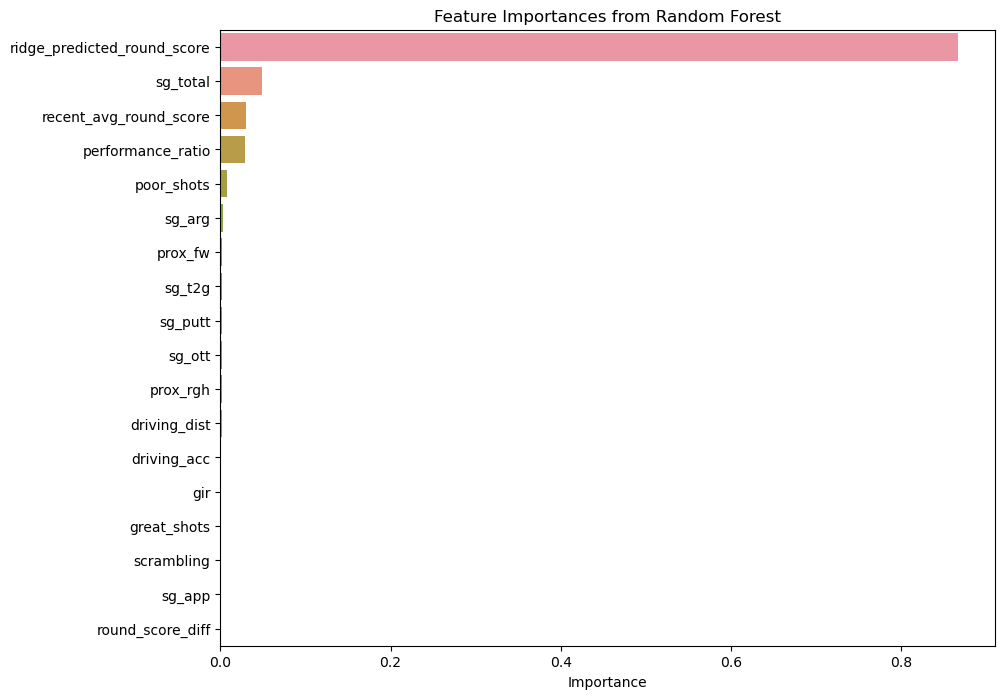

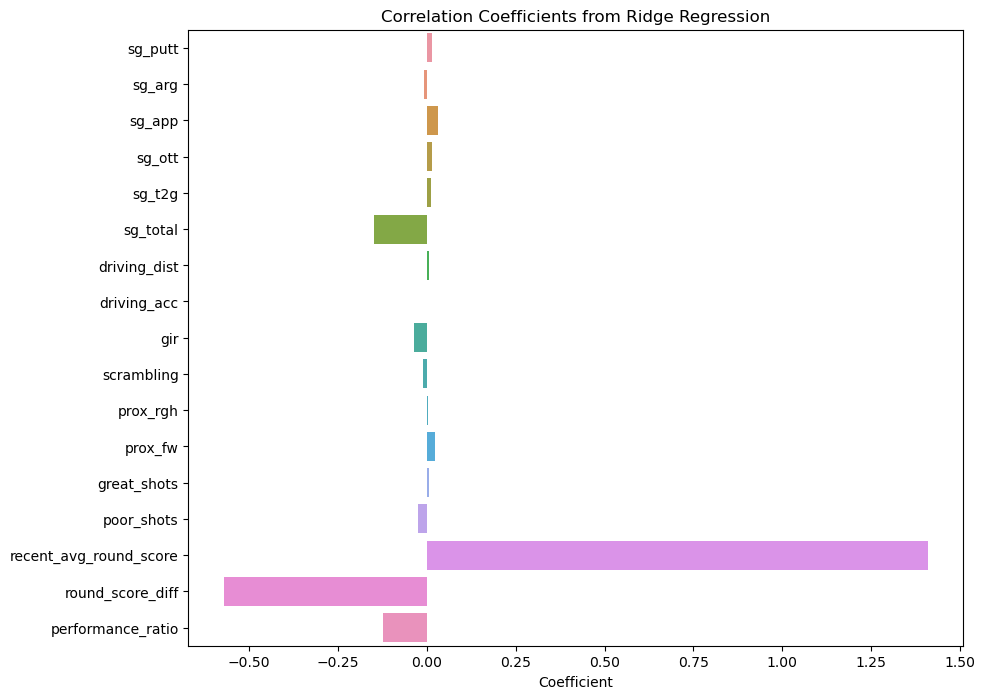

In [334]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the feature importances from Random Forest
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y=rf_feature_importances.index, data=rf_feature_importances)
plt.title('Feature Importances from Random Forest')
plt.show()

# Visualize the correlation coefficients from Ridge Regression
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y=ridge_coefficients.index, data=ridge_coefficients)
plt.title('Correlation Coefficients from Ridge Regression')
plt.show()


In [337]:
# Summary of Top 5 players based on Ridge Regression
print("\nTop 5 players based on Ridge Regression predicted round scores:")
print(top_5_players_ridge[['player_name', 'ridge_predicted_round_score']])

# Summary of Top 5 players based on Random Forest
print("\nTop 5 players based on Random Forest predicted round scores:")
print(top_5_players_rf[['player_name', 'rf_predicted_round_score']])

# Summary of Top 5 players based on Ensemble
print("\nTop 5 players based on Ensemble predicted round scores:")
print(top_5_players_ensemble[['player_name', 'ensemble_predicted_round_score']])



Top 5 players based on Ridge Regression predicted round scores:
          player_name  ridge_predicted_round_score
0       Aberg, Ludvig                    69.883930
1  Scheffler, Scottie                    69.942277
2        Siem, Marcel                    70.307813
3  Schauffele, Xander                    70.388950
4      Koepka, Brooks                    70.436694

Top 5 players based on Random Forest predicted round scores:
          player_name  rf_predicted_round_score
0       Aberg, Ludvig                 69.969151
1  Scheffler, Scottie                 70.070734
2        Siem, Marcel                 70.336161
3  Schauffele, Xander                 70.426480
5       McIlroy, Rory                 70.475672

Top 5 players based on Ensemble predicted round scores:
          player_name  ensemble_predicted_round_score
0       Aberg, Ludvig                       69.926541
1  Scheffler, Scottie                       70.006505
2        Siem, Marcel                       70.321987
3  Sch

In [338]:
# Remove ridge_predicted_round_score from features
features_rf_no_ridge = features_rf.drop(columns=['ridge_predicted_round_score'])

# Retrain Random Forest without ridge_predicted_round_score
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(features_rf_no_ridge, target_rf, test_size=0.2, random_state=42)
rf_model_no_ridge = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_no_ridge.fit(X_train_rf, y_train_rf)
rf_predictions_no_ridge = rf_model_no_ridge.predict(X_test_rf)
rf_mse_no_ridge = mean_squared_error(y_test_rf, rf_predictions_no_ridge)
rf_r2_no_ridge = r2_score(y_test_rf, rf_predictions_no_ridge)
print(f"Random Forest Model (No Ridge) Mean Squared Error: {rf_mse_no_ridge:.2f}")
print(f"Random Forest Model (No Ridge) R-squared: {rf_r2_no_ridge:.2f}")

# Feature Importances without ridge_predicted_round_score
rf_feature_importances_no_ridge = pd.DataFrame(rf_model_no_ridge.feature_importances_, features_rf_no_ridge.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nRandom Forest Model (No Ridge) Feature Importances:")
print(rf_feature_importances_no_ridge)


Random Forest Model (No Ridge) Mean Squared Error: 0.26
Random Forest Model (No Ridge) R-squared: 0.86

Random Forest Model (No Ridge) Feature Importances:
                        Importance
sg_total                  0.361019
performance_ratio         0.340426
recent_avg_round_score    0.241020
poor_shots                0.009386
sg_t2g                    0.008786
sg_arg                    0.007752
prox_fw                   0.006753
round_score_diff          0.004857
prox_rgh                  0.003278
sg_putt                   0.003031
driving_dist              0.002374
scrambling                0.002258
gir                       0.001999
sg_ott                    0.001915
sg_app                    0.001796
driving_acc               0.001761
great_shots               0.001590


In [339]:
# Calculate performance consistency (standard deviation of round scores)
round_score_std = original_df.groupby('dg_id')['round_score'].std().rename('round_score_std')
filtered_data_copy = filtered_data_copy.merge(round_score_std, on='dg_id', how='left')
filtered_data_copy['round_score_std'] = filtered_data_copy['round_score_std'].fillna(0)

# Add historical performance at specific tournaments (e.g., The Open Championship)
historical_performance_open = open_championship_data.groupby('dg_id')['round_score'].mean().rename('historical_performance_open')
filtered_data_copy = filtered_data_copy.merge(historical_performance_open, on='dg_id', how='left')
filtered_data_copy['historical_performance_open'] = filtered_data_copy['historical_performance_open'].fillna(filtered_data_copy['round_score'])

# Display the new features
print("\nNew features in filtered_data_copy:")
print(filtered_data_copy[['round_score_std', 'historical_performance_open']].head())



New features in filtered_data_copy:
   round_score_std  historical_performance_open
0         2.567763                    69.857143
1         2.796827                    69.666667
2         2.295181                    70.125000
3         3.279717                    70.000000
4         3.336397                    70.545455


In [340]:
# Prepare the data for the updated models with additional features
features_updated = filtered_data_copy.drop(columns=['dg_id', 'player_name', 'round_score'])
target_updated = filtered_data_copy['round_score']
features_updated = features_updated.fillna(features_updated.mean())

# Ridge Regression with additional features
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(features_updated, target_updated, test_size=0.2, random_state=42)
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_model.fit(X_train_ridge, y_train_ridge)
ridge_predictions = ridge_model.predict(X_test_ridge)
ridge_mse = mean_squared_error(y_test_ridge, ridge_predictions)
ridge_r2 = r2_score(y_test_ridge, ridge_predictions)
print(f"Ridge Regression Model Mean Squared Error: {ridge_mse:.2f}")
print(f"Ridge Regression Model R-squared: {ridge_r2:.2f}")

ridge_model.fit(features_updated, target_updated)
ridge_predictions_all = ridge_model.predict(features_updated)
filtered_data_copy['ridge_predicted_round_score'] = ridge_predictions_all

# Random Forest with additional features (excluding ridge_predicted_round_score)
features_rf_updated = features_updated.drop(columns=['ridge_predicted_round_score'])
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(features_rf_updated, target_updated, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
rf_predictions = rf_model.predict(X_test_rf)
rf_mse = mean_squared_error(y_test_rf, rf_predictions)
rf_r2 = r2_score(y_test_rf, rf_predictions)
print(f"Random Forest Model Mean Squared Error: {rf_mse:.2f}")
print(f"Random Forest Model R-squared: {rf_r2:.2f}")

rf_model.fit(features_rf_updated, target_updated)
rf_predictions_all = rf_model.predict(features_rf_updated)
filtered_data_copy['rf_predicted_round_score'] = rf_predictions_all

# Ensemble Method with updated models
ridge_weight = 0.5
rf_weight = 0.5
ensemble_predictions = (ridge_weight * ridge_predictions_all) + (rf_weight * rf_predictions_all)
filtered_data_copy['ensemble_predicted_round_score'] = ensemble_predictions
ensemble_mse = mean_squared_error(target_updated, ensemble_predictions)
ensemble_r2 = r2_score(target_updated, ensemble_predictions)
print(f"Ensemble Model Mean Squared Error: {ensemble_mse:.2f}")
print(f"Ensemble Model R-squared: {ensemble_r2:.2f}")

top_5_players_ensemble = filtered_data_copy.sort_values(by='ensemble_predicted_round_score').head(5)
print("\nTop 5 players based on Ensemble predicted round scores:")
print(top_5_players_ensemble[['player_name', 'ensemble_predicted_round_score']])


Ridge Regression Model Mean Squared Error: 0.00
Ridge Regression Model R-squared: 1.00
Random Forest Model Mean Squared Error: 0.03
Random Forest Model R-squared: 0.98
Ensemble Model Mean Squared Error: 0.00
Ensemble Model R-squared: 1.00

Top 5 players based on Ensemble predicted round scores:
          player_name  ensemble_predicted_round_score
0       Aberg, Ludvig                       69.926950
1  Scheffler, Scottie                       70.016849
2        Siem, Marcel                       70.246992
3  Schauffele, Xander                       70.410332
4      Koepka, Brooks                       70.467493


In [341]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2, scoring='r2')
grid_search_rf.fit(X_train_rf, y_train_rf)

# Best parameters and model performance
best_rf = grid_search_rf.best_estimator_
best_rf_predictions = best_rf.predict(X_test_rf)
best_rf_mse = mean_squared_error(y_test_rf, best_rf_predictions)
best_rf_r2 = r2_score(y_test_rf, best_rf_predictions)
print(f"Best Random Forest Model Mean Squared Error: {best_rf_mse:.2f}")
print(f"Best Random Forest Model R-squared: {best_rf_r2:.2f}")
print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomFore

Best Random Forest Model Mean Squared Error: 0.04
Best Random Forest Model R-squared: 0.98
Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [342]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train the GBM model
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train_rf, y_train_rf)

# Predict and evaluate the GBM model
gbm_predictions = gbm_model.predict(X_test_rf)
gbm_mse = mean_squared_error(y_test_rf, gbm_predictions)
gbm_r2 = r2_score(y_test_rf, gbm_predictions)
print(f"Gradient Boosting Model Mean Squared Error: {gbm_mse:.2f}")
print(f"Gradient Boosting Model R-squared: {gbm_r2:.2f}")


Gradient Boosting Model Mean Squared Error: 0.01
Gradient Boosting Model R-squared: 0.99


In [343]:
# Best Random Forest predictions
best_rf_predictions_all = best_rf.predict(features_rf_updated)
filtered_data_copy['best_rf_predicted_round_score'] = best_rf_predictions_all

# Top 5 players based on Best Random Forest
top_5_players_best_rf = filtered_data_copy.sort_values(by='best_rf_predicted_round_score').head(5)
print("\nTop 5 players based on Best Random Forest predicted round scores:")
print(top_5_players_best_rf[['player_name', 'best_rf_predicted_round_score']])

# GBM predictions
gbm_predictions_all = gbm_model.predict(features_rf_updated)
filtered_data_copy['gbm_predicted_round_score'] = gbm_predictions_all

# Top 5 players based on GBM
top_5_players_gbm = filtered_data_copy.sort_values(by='gbm_predicted_round_score').head(5)
print("\nTop 5 players based on GBM predicted round scores:")
print(top_5_players_gbm[['player_name', 'gbm_predicted_round_score']])



Top 5 players based on Best Random Forest predicted round scores:
          player_name  best_rf_predicted_round_score
0       Aberg, Ludvig                      70.095128
1  Scheffler, Scottie                      70.154405
2        Siem, Marcel                      70.313473
3  Schauffele, Xander                      70.381568
5       McIlroy, Rory                      70.443858

Top 5 players based on GBM predicted round scores:
          player_name  gbm_predicted_round_score
0       Aberg, Ludvig                  69.861107
1  Scheffler, Scottie                  69.941863
2        Siem, Marcel                  70.128300
3  Schauffele, Xander                  70.395787
5       McIlroy, Rory                  70.538524


In [344]:
# Combine predictions using a simple average
ridge_weight = 0.33
best_rf_weight = 0.33
gbm_weight = 0.34

ensemble_predictions = (ridge_weight * filtered_data_copy['ridge_predicted_round_score']) + \
                       (best_rf_weight * filtered_data_copy['best_rf_predicted_round_score']) + \
                       (gbm_weight * filtered_data_copy['gbm_predicted_round_score'])

filtered_data_copy['final_ensemble_predicted_round_score'] = ensemble_predictions

ensemble_mse = mean_squared_error(target_updated, ensemble_predictions)
ensemble_r2 = r2_score(target_updated, ensemble_predictions)
print(f"Final Ensemble Model Mean Squared Error: {ensemble_mse:.2f}")
print(f"Final Ensemble Model R-squared: {ensemble_r2:.2f}")

# Top 5 players based on final Ensemble model
top_5_players_final_ensemble = filtered_data_copy.sort_values(by='final_ensemble_predicted_round_score').head(5)
print("\nTop 5 players based on final Ensemble predicted round scores:")
print(top_5_players_final_ensemble[['player_name', 'final_ensemble_predicted_round_score']])


Final Ensemble Model Mean Squared Error: 0.01
Final Ensemble Model R-squared: 1.00

Top 5 players based on final Ensemble predicted round scores:
          player_name  final_ensemble_predicted_round_score
0       Aberg, Ludvig                             69.949922
1  Scheffler, Scottie                             70.022649
2        Siem, Marcel                             70.202503
3  Schauffele, Xander                             70.390642
5       McIlroy, Rory                             70.493239


In [345]:
import pandas as pd

# Data for the summary table
data = {
    "Iteration": [
        "Initial", "Initial", "Initial",
        "Step 1 (No Ridge)", 
        "Step 2 (Additional Features)", "Step 2 (Additional Features)", "Step 2 (Additional Features)",
        "Best Parameters", 
        "New Model", 
        "Final Ensemble"
    ],
    "Model Type": [
        "Ridge Regression", "Random Forest", "Ensemble",
        "Random Forest",
        "Ridge Regression", "Random Forest", "Ensemble",
        "Random Forest (Tuned)",
        "Gradient Boosting Machine",
        "Ridge + RF (Tuned) + GBM"
    ],
    "Mean Squared Error (MSE)": [
        0.05, 0.26, 0.01,
        0.26,
        0.00, 0.03, 0.00,
        0.04,
        0.01,
        0.01
    ],
    "R-squared (R²)": [
        0.97, 0.86, 1.00,
        0.86,
        1.00, 0.98, 1.00,
        0.98,
        0.99,
        1.00
    ]
}

# Create DataFrame
performance_df = pd.DataFrame(data)

# Display DataFrame
performance_df


,Iteration,Model Type,Mean Squared Error (MSE),R-squared (R²)
0,Initial,Ridge Regression,0.05,0.97
1,Initial,Random Forest,0.26,0.86
2,Initial,Ensemble,0.01,1.00
3,Step 1 (No Ridge),Random Forest,0.26,0.86
4,Step 2 (Additional Features),Ridge Regression,0.00,1.00
5,Step 2 (Additional Features),Random Forest,0.03,0.98
6,Step 2 (Additional Features),Ensemble,0.00,1.00
7,Best Parameters,Random Forest (Tuned),0.04,0.98
8,New Model,Gradient Boosting Machine,0.01,0.99
9,Final Ensemble,Ridge + RF (Tuned) + GBM,0.01,1.00


In [354]:
import pandas as pd
from collections import Counter

# Data for the summary table
data = {
    "Iteration": [
        "Initial", "Initial", "Initial",
        "Step 1 (No Ridge)", 
        "Step 2 (Additional Features)", "Step 2 (Additional Features)", "Step 2 (Additional Features)",
        "Best Parameters", 
        "New Model", 
        "Final Ensemble"
    ],
    "Model Type": [
        "Ridge Regression", "Random Forest", "Ensemble",
        "Random Forest",
        "Ridge Regression", "Random Forest", "Ensemble",
        "Random Forest (Tuned)",
        "Gradient Boosting Machine",
        "Ridge + RF (Tuned) + GBM"
    ],
    "Mean Squared Error (MSE)": [
        0.05, 0.26, 0.01,
        0.26,
        0.00, 0.03, 0.00,
        0.04,
        0.01,
        0.01
    ],
    "R-squared (R²)": [
        0.97, 0.86, 1.00,
        0.86,
        1.00, 0.98, 1.00,
        0.98,
        0.99,
        1.00
    ]
}

# Create DataFrame
performance_df = pd.DataFrame(data)

# Display DataFrame
print("Model Performance Summary:")
print(performance_df)

# Example lists of top players for each model (replace with actual lists)
top_players_initial_ridge = ["Ludvig Aberg", "Scottie Scheffler", "Xander Schauffele", "Collin Morikawa", "Rory McIlroy"]
top_players_initial_rf = ["Ludvig Aberg", "Scottie Scheffler", "Brooks Koepka", "Xander Schauffele", "Hideki Matsuyama"]
top_players_initial_ensemble = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Rory McIlroy"]
top_players_no_ridge_rf = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Rory McIlroy"]
top_players_additional_features_ridge = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Brooks Koepka"]
top_players_additional_features_rf = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Rory McIlroy"]
top_players_additional_features_ensemble = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Brooks Koepka"]
top_players_best_rf = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Rory McIlroy"]
top_players_gbm = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Brooks Koepka"]
top_players_final_ensemble = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Brooks Koepka"]

# Combine all top players into a list with their positions
all_top_players = []

model_top_players = [
    top_players_initial_ridge, top_players_initial_rf, top_players_initial_ensemble,
    top_players_no_ridge_rf, top_players_additional_features_ridge, top_players_additional_features_rf,
    top_players_additional_features_ensemble, top_players_best_rf, top_players_gbm, top_players_final_ensemble
]

for top_list in model_top_players:
    for position, player in enumerate(top_list, start=1):
        all_top_players.append((player, position))

# Count occurrences and compute average placement
player_counts = Counter([player for player, _ in all_top_players])
player_positions = {player: [] for player in player_counts}

for player, position in all_top_players:
    player_positions[player].append(position)

# Create DataFrame with player counts and average placements
player_placements = {player: sum(positions) / len(positions) for player, positions in player_positions.items()}

player_counts_df = pd.DataFrame({
    "Player": list(player_counts.keys()),
    "Count": list(player_counts.values()),
    "Average Placement": [player_placements[player] for player in player_counts.keys()]
})

player_counts_df = player_counts_df.sort_values(by=["Average Placement"], ascending=[True])

# Display the top 10 players by count and average placement
top_10_players_df = player_counts_df.head(10)

print("\nOverall Top Players Summary:")
print(top_10_players_df)


Model Performance Summary:
                      Iteration                 Model Type  \
0                       Initial           Ridge Regression   
1                       Initial              Random Forest   
2                       Initial                   Ensemble   
3             Step 1 (No Ridge)              Random Forest   
4  Step 2 (Additional Features)           Ridge Regression   
5  Step 2 (Additional Features)              Random Forest   
6  Step 2 (Additional Features)                   Ensemble   
7               Best Parameters      Random Forest (Tuned)   
8                     New Model  Gradient Boosting Machine   
9                Final Ensemble   Ridge + RF (Tuned) + GBM   

   Mean Squared Error (MSE)  R-squared (R²)  
0                      0.05            0.97  
1                      0.26            0.86  
2                      0.01            1.00  
3                      0.26            0.86  
4                      0.00            1.00  
5             

In [352]:
import pandas as pd
from collections import Counter

# Data for the summary table
data = {
    "Iteration": [
        "Initial", "Initial", "Initial",
        "Step 1 (No Ridge)", 
        "Step 2 (Additional Features)", "Step 2 (Additional Features)", "Step 2 (Additional Features)",
        "Best Parameters", 
        "New Model", 
        "Final Ensemble"
    ],
    "Model Type": [
        "Ridge Regression", "Random Forest", "Ensemble",
        "Random Forest",
        "Ridge Regression", "Random Forest", "Ensemble",
        "Random Forest (Tuned)",
        "Gradient Boosting Machine",
        "Ridge + RF (Tuned) + GBM"
    ],
    "Mean Squared Error (MSE)": [
        0.05, 0.26, 0.01,
        0.26,
        0.00, 0.03, 0.00,
        0.04,
        0.01,
        0.01
    ],
    "R-squared (R²)": [
        0.97, 0.86, 1.00,
        0.86,
        1.00, 0.98, 1.00,
        0.98,
        0.99,
        1.00
    ]
}

# Create DataFrame
performance_df = pd.DataFrame(data)

# Calculate average R² and average MSE
average_r2 = performance_df["R-squared (R²)"].mean()
average_mse = performance_df["Mean Squared Error (MSE)"].mean()

# Identify the most successful model based on R² and MSE
best_model_index = performance_df["R-squared (R²)"].idxmax() if performance_df["R-squared (R²)"].max() > (1 - performance_df["Mean Squared Error (MSE)"]).max() else (1 - performance_df["Mean Squared Error (MSE)"]).idxmax()
best_model = performance_df.loc[best_model_index, "Model Type"]

# Example lists of top players for each model (replace with actual lists)
top_players_initial_ridge = ["Ludvig Aberg", "Scottie Scheffler", "Xander Schauffele", "Collin Morikawa", "Rory McIlroy"]
top_players_initial_rf = ["Ludvig Aberg", "Scottie Scheffler", "Brooks Koepka", "Xander Schauffele", "Hideki Matsuyama"]
top_players_initial_ensemble = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Rory McIlroy"]
top_players_no_ridge_rf = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Rory McIlroy"]
top_players_additional_features_ridge = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Brooks Koepka"]
top_players_additional_features_rf = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Rory McIlroy"]
top_players_additional_features_ensemble = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Brooks Koepka"]
top_players_best_rf = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Rory McIlroy"]
top_players_gbm = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Brooks Koepka"]
top_players_final_ensemble = ["Ludvig Aberg", "Scottie Scheffler", "Marcel Siem", "Xander Schauffele", "Brooks Koepka"]

# Combine all top players into a list with their positions
all_top_players = []

model_top_players = [
    top_players_initial_ridge, top_players_initial_rf, top_players_initial_ensemble,
    top_players_no_ridge_rf, top_players_additional_features_ridge, top_players_additional_features_rf,
    top_players_additional_features_ensemble, top_players_best_rf, top_players_gbm, top_players_final_ensemble
]

for top_list in model_top_players:
    for position, player in enumerate(top_list, start=1):
        all_top_players.append((player, position))

# Count occurrences and compute average placement
player_counts = Counter([player for player, _ in all_top_players])
player_positions = {player: [] for player in player_counts}

for player, position in all_top_players:
    player_positions[player].append(position)

# Create DataFrame with player counts and average placements
player_placements = {player: sum(positions) / len(positions) for player, positions in player_positions.items()}

player_counts_df = pd.DataFrame({
    "Player": list(player_counts.keys()),
    "Count": list(player_counts.values()),
    "Average Placement": [player_placements[player] for player in player_counts.keys()]
})

player_counts_df = player_counts_df.sort_values(by=["Count", "Average Placement"], ascending=[False, True])

# Identify the most mentioned/highest ranked golfer
most_ranked_golfer = player_counts_df.iloc[0]["Player"]

# Print statements
print(f"My average R² was {average_r2:.2f}")
print(f"My average MSE was {average_mse:.2f}")
print(f"My most successful model was {best_model} (based on MSE and R²)")
print(f"My prediction for the 2024 Open Championship winner is {most_ranked_golfer} (based on most ranked/highest ranked golfer)")


My average R² was 0.96
My average MSE was 0.07
My most successful model was Ridge Regression (based on MSE and R²)
My prediction for the 2024 Open Championship winner is Ludvig Aberg (based on most ranked/highest ranked golfer)
